# 一、GBDT回归树预测

## 1. 建模

In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

### 实际问题，年龄预测，回归问题
# 简单的数据，算法原理，无论简单数据，还是复杂数据，都一样
# 属性一表示花销，属性二表示上网时间
X = np.array([[600,0.8],[800,1.2],[1500,10],[2500,3]])
y = np.array([14,16,24,26]) # 高一、高三，大四，工作两年

learning_rate = 0.1
gbdt = GradientBoostingRegressor(n_estimators=3,
                                 loss = 'squared_error', # 最小二乘法
                                 learning_rate=0.1)      # learning_rate 学习率
gbdt.fit(X,y)#训练
y_ = gbdt.predict(X)#预测
y_

array([18.374, 18.916, 21.084, 21.626])

In [2]:
gbdt.predict([[605,0.75]]) # 测试数据

array([18.374])

## 2. 计算残差

In [11]:
# 目标值，真实值，算法，希望，预测，越接近真实，模型越好！！！
print(y)
# 求平均，这个平均值就是算法第一次预测的基准，初始值
print(y.mean())
# 残差：真实值，和预测值之间的差
residual = y - y.mean()
residual
# 残差，越小越好
# 如果残差是0，算法完全准确的把数值预测出来！

[14 16 24 26]
20.0


array([-6., -4.,  4.,  6.])

## 3. 可视化第一棵树

In [4]:
# 第一颗树，分叉时，friedman-mse (就是均方误差)= 26
print('均方误差：',((y - y.mean())**2).mean())
dot_data = tree.export_graphviz(gbdt[0,0],filled=True)
graph = graphviz.Source(dot_data)
graph.render('./第一棵树',format='png')

均方误差： 26.0


'第一棵树.png'

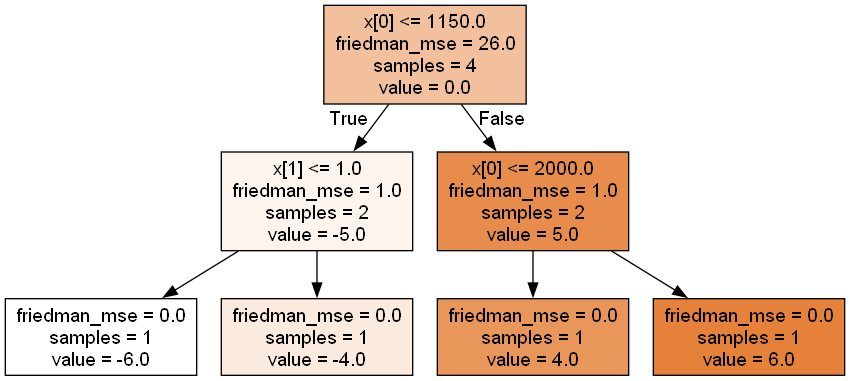

In [12]:
# value就是上面计算的残差
residual

array([-6., -4.,  4.,  6.])

In [ ]:
# 提升

In [13]:
residual -= residual * learning_rate
residual  # 第二棵树的value

array([-5.4, -3.6,  3.6,  5.4])

In [14]:
(residual**2).mean()  # 第二棵树的 mse

21.060000000000002

## 4. 第二棵树

In [6]:
# 第二棵树
dot_data = tree.export_graphviz(gbdt[1,0],filled=True)
graph = graphviz.Source(dot_data)
graph.render('./第二棵树',format='png')

'第二棵树.png'

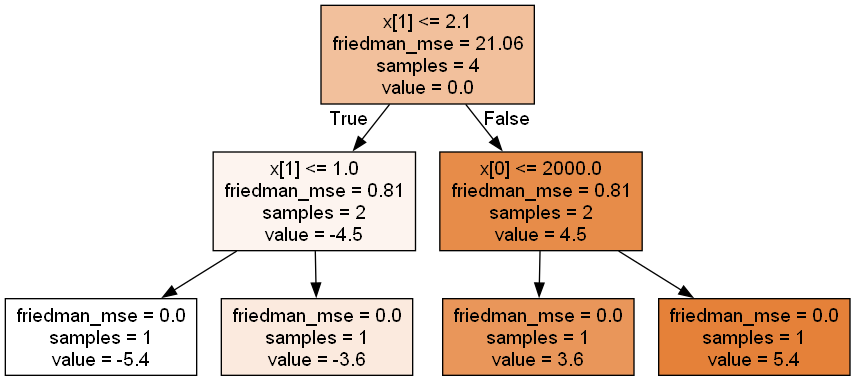

In [15]:
residual -= residual * learning_rate
residual

array([-4.86, -3.24,  3.24,  4.86])

In [16]:
np.round((residual**2).mean(),3)

17.059

## 5. 第三棵树

In [7]:
# 第三棵树
dot_data = tree.export_graphviz(gbdt[2,0],filled=True)
graph = graphviz.Source(dot_data)
graph.render('./第三棵树',format='png')

'第三棵树.png'

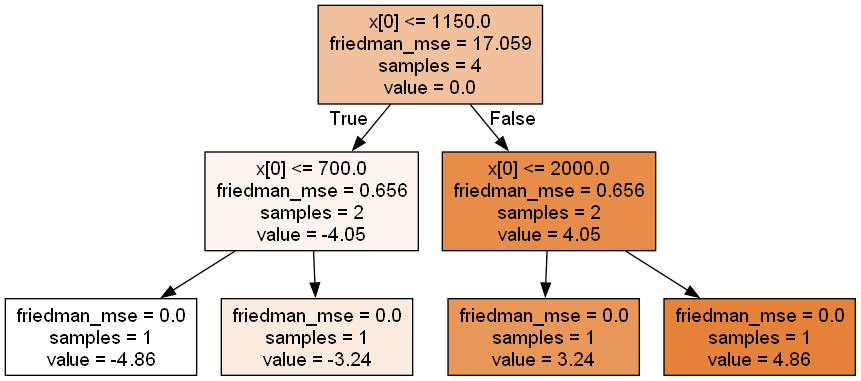

In [17]:
residual

array([-4.86, -3.24,  3.24,  4.86])

In [18]:
# 在第三棵树的基础上继续提升
residual -= residual * learning_rate
residual

array([-4.374, -2.916,  2.916,  4.374])

In [19]:
# 预测值：实际值 - 残差
y - residual

array([18.374, 18.916, 21.084, 21.626])

In [20]:
gbdt.predict(X)

array([18.374, 18.916, 21.084, 21.626])

In [21]:
gbdt.predict([[605,0.75]]) # 测试数据  发现输出还是上面的第一个

array([18.374])

In [ ]:
# 测试数据还是用的之前用训练数据训练的模型，逐级判断，最后落到某一个叶节点上
# 到哪个叶节点上就对应那个预测值

# 二、XGBoost

## 1. XGBoost 用法之一

In [44]:
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

In [22]:
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier,XGBRFRegressor
from sklearn import datasets
from sklearn import tree
from sklearn.model_selection import train_test_split
X,y = datasets.load_wine(return_X_y=True) # 葡萄酒数据

In [25]:
np.unique(y) # 三分类

array([0, 1, 2])

In [26]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [43]:
model = XGBClassifier(learning_rate =0.1, # 学习率，控制每次迭代更新权重时的步长，默认0.3。值越小，训练越慢。
                      n_estimators=20,   # 总共迭代的次数，即决策树的个数
                      early_stopping_rounds = 10, # 在验证集上，当连续 n次迭代，分数没有提高后，提前终止训练
                      max_depth=5, # 深度
                      min_child_weight=1, # 默认值为 1,值越大，越容易欠拟合；值越小，越容易过拟合
                      gamma=0,       # 惩罚项系数，指定节点分裂所需的最小损失函数下降值。
                      subsample=0.8, # 训练每棵树时，使用的数据占全部训练集的比例。默认值为 1，典型值为 0.5-1。防止过拟合
                      colsample_bytree=0.8, #训练每棵树时，使用的特征占全部特征的比例。默认值为1典型值为0.5-1。防止过拟合
                      objective= 'binary:logistic',# 目标函数
                      eval_metric = ['merror'],    # 验证数据集评判标准
                      nthread=4,  # 并行线程数
                      verbosity = 1)   # 有效值为 0（静默），1（警告），2（信息），3（调试）   

In [46]:
eval_set = [(X_test, y_test),(X_train,y_train)]
model.fit(X_train,y_train,eval_set = eval_set,verbose = True)
model.score(X_test,y_test)

[0]	validation_0-merror:0.16667	validation_1-merror:0.02817
[1]	validation_0-merror:0.05556	validation_1-merror:0.00704
[2]	validation_0-merror:0.02778	validation_1-merror:0.00704
[3]	validation_0-merror:0.05556	validation_1-merror:0.00704
[4]	validation_0-merror:0.02778	validation_1-merror:0.00000
[5]	validation_0-merror:0.02778	validation_1-merror:0.00000
[6]	validation_0-merror:0.02778	validation_1-merror:0.00000
[7]	validation_0-merror:0.02778	validation_1-merror:0.00000
[8]	validation_0-merror:0.02778	validation_1-merror:0.00000
[9]	validation_0-merror:0.00000	validation_1-merror:0.00000
[10]	validation_0-merror:0.00000	validation_1-merror:0.00000
[11]	validation_0-merror:0.00000	validation_1-merror:0.00000
[12]	validation_0-merror:0.00000	validation_1-merror:0.00000
[13]	validation_0-merror:0.00000	validation_1-merror:0.00000


0.9722222222222222

In [ ]:
# 每一行输出代表一棵树，为什么上面这个只输出了14行？  设置了 early_stopping_rounds = 10

In [45]:
eval_set = [(X_test, y_test)]  # 删掉一列
model.fit(X_train,y_train,eval_set = eval_set,verbose = True)
model.score(X_test,y_test)

[0]	validation_0-merror:0.16667
[1]	validation_0-merror:0.05556
[2]	validation_0-merror:0.02778
[3]	validation_0-merror:0.05556
[4]	validation_0-merror:0.02778
[5]	validation_0-merror:0.02778
[6]	validation_0-merror:0.02778
[7]	validation_0-merror:0.02778
[8]	validation_0-merror:0.02778
[9]	validation_0-merror:0.00000
[10]	validation_0-merror:0.00000
[11]	validation_0-merror:0.00000
[12]	validation_0-merror:0.00000
[13]	validation_0-merror:0.00000
[14]	validation_0-merror:0.00000
[15]	validation_0-merror:0.00000
[16]	validation_0-merror:0.00000
[17]	validation_0-merror:0.00000
[18]	validation_0-merror:0.00000
[19]	validation_0-merror:0.00000


1.0

In [47]:
eval_set = [(X_test, y_test),(X_train,y_train)]
model.fit(X_train,y_train,eval_set = eval_set,verbose = False) # 不输出详细信息
model.score(X_test,y_test)

0.9722222222222222

## 2. XGBoost使用方式之二

In [48]:
X,y = datasets.load_wine(return_X_y=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [49]:
param = {'learning_rate':0.1,'n_estimators':10000,
         'max_depth':5,'min_child_weight':1,'gamma':0,'subsample':0.8,
         'colsample_bytree':0.8, 'verbosity':0,'objective':'multi:softprob',
         'eval_metric':'merror','early_stopping_rounds':20}

model = xgb.XGBClassifier(**param)
model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
model.score(X_test,y_test)

[0]	validation_0-merror:0.11111
[1]	validation_0-merror:0.11111
[2]	validation_0-merror:0.05556
[3]	validation_0-merror:0.00000
[4]	validation_0-merror:0.00000
[5]	validation_0-merror:0.00000
[6]	validation_0-merror:0.00000
[7]	validation_0-merror:0.00000
[8]	validation_0-merror:0.00000
[9]	validation_0-merror:0.00000
[10]	validation_0-merror:0.00000
[11]	validation_0-merror:0.00000
[12]	validation_0-merror:0.00000
[13]	validation_0-merror:0.00000
[14]	validation_0-merror:0.00000
[15]	validation_0-merror:0.00000
[16]	validation_0-merror:0.00000
[17]	validation_0-merror:0.00000
[18]	validation_0-merror:0.00000
[19]	validation_0-merror:0.00000
[20]	validation_0-merror:0.00000
[21]	validation_0-merror:0.00000
[22]	validation_0-merror:0.00000


1.0

## 3. XGBoost使用方式之三

DMatrix是XGBoost中使用的数据矩阵。DMatrix是XGBoost使用的内部数据结构，它针对内存效率和训练速度进行了优化

In [52]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn import datasets
X,y = datasets.load_wine(return_X_y=True)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

# 创建数据
dtrain = xgb.DMatrix(data = X_train,label = y_train)
dtest = xgb.DMatrix(data = X_test,label = y_test)


# 指定参数
param = {'learning_rate':0.1,'max_depth':5,
         'min_child_weight':1,'gamma':0,'subsample':0.8,'eval_metric':['merror'],
         'colsample_bytree':0.1, 'verbosity':0,'objective':'multi:softmax','num_class':3}

num_round = 100
evals = [(dtest,'eval')] # 评估 验证集，一般只需要给test？？？

# 直接调用模块的train函数，进行了建模
model = xgb.train(param, dtrain,num_round,evals = evals,early_stopping_rounds=10) 
             # 如果early_stopping_rounds写在param里，它就不起作用

# 进行预测
y_ = model.predict(dtest)
display(y_,accuracy_score(y_test,y_))

[0]	eval-merror:0.50000
[1]	eval-merror:0.33333
[2]	eval-merror:0.13889
[3]	eval-merror:0.19444
[4]	eval-merror:0.19444
[5]	eval-merror:0.11111
[6]	eval-merror:0.08333
[7]	eval-merror:0.08333
[8]	eval-merror:0.08333
[9]	eval-merror:0.08333
[10]	eval-merror:0.08333
[11]	eval-merror:0.08333
[12]	eval-merror:0.08333
[13]	eval-merror:0.08333
[14]	eval-merror:0.08333
[15]	eval-merror:0.08333
[16]	eval-merror:0.02778
[17]	eval-merror:0.02778
[18]	eval-merror:0.02778
[19]	eval-merror:0.02778
[20]	eval-merror:0.02778
[21]	eval-merror:0.02778
[22]	eval-merror:0.02778
[23]	eval-merror:0.02778
[24]	eval-merror:0.02778
[25]	eval-merror:0.02778
[26]	eval-merror:0.05556


array([1., 0., 0., 2., 0., 1., 1., 0., 2., 0., 2., 1., 1., 1., 2., 0., 0.,
       1., 1., 0., 1., 0., 0., 2., 1., 0., 0., 1., 0., 2., 1., 2., 2., 0.,
       1., 2.], dtype=float32)

0.9444444444444444